In [45]:
%pylab inline
import scipy.stats as stats
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML, Image

rc('animation', html='html5')

Populating the interactive namespace from numpy and matplotlib


/home/vagrant/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In our last example, we saw that we can use a permutation test to quantify our confidence in an election outcome based on a sample drawn from an audit. However, we also saw that permutation testing isn't really feasible for real election results, since the number of comptuations necessary for a permutation test grows exponentially. 

Here we set out to address those challenges. If we can find a reasonable approximation of our permutation distribution, then maybe we can get somewhere. Let's start by recalling what we saw last time:

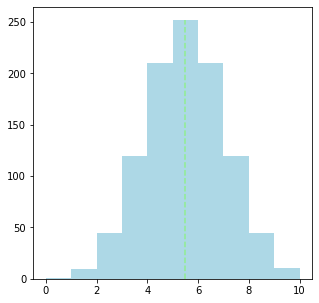

In [46]:
n = 10
margins = np.zeros(2**n)
for i in range(2**n):
    margins[i] = (np.sum([int(j) for j in list('{0:0b}'.format(i))]))

fig, ax = plt.subplots(figsize=(5,5))
counts, bins, _ = ax.hist(margins, color='lightblue')
ax.vlines(5.5, color='lightgreen', linestyle='dashed', ymin=0, ymax=max(counts))

Recall that we saw the total distribution of possible elections in the histogram above. With no knowledge about a specific election outcome, the distribution is distributed evenly around the midpoint outcome: a tie. We also saw that we can redraw this distribution so that rather than showing us a histogram, we get a summary of the probabilities of the various election outcomes. To use the parlance of probability, this new diagram shows a probability mass function (PMF), which can be seen below.

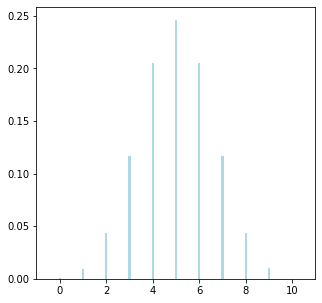

In [47]:
ax.cla()
counts, bins, _ = ax.hist(margins, bins=np.arange(0, 11), color='lightblue', density=True, rwidth=.1, align='left')
ax.set_xlim(-1, 11)
fig

Because it's impossible to have a fractional outcome, we show the various points without any filled in space between. The eagle-eyed among you may have by this point noted that that kind of looks a little bit like a normal distribution. Indeed, it does!

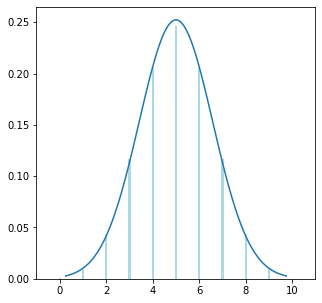

In [48]:
ax.cla()
mu = .5*n
variance = n*.5*(1 - .5)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
ax.hist(margins, bins=np.arange(0, 11), color='lightblue', density=True, rwidth=.1, align='left')
ax.set_xlim(-1, 11)
fig

Look at that! It's almost a perfect fit! Why is that?

This is a result of the Central Limit Theorem, which says that as n (in this case, the number of ballots) goes to infinity, the distribution of outcomes approaches a normal distribution. But how does this help us?

Going to our example from yesterday, a contest between Alice and Bob with no invalid votes. We saw yesterday how as we sampled more ballots, the distribution shifted toward the "true" underlying margin. Think about what we're doing here: we're conducting _trials_ with outcomes of 1 or 0, in series. Each of these trials is independent of each other. Wait a minute, that means they're Bernoulli trials! And when we do a bunch of them together, we get a Binomial distribution! 

Thanks to a special case of the CLT, the De Moivre-Laplace theorem, we can use our binomial distribution to build a normal. You may have noticed the specific values I put in above to generate the normal. Those come straight from the De Moivre-Laplace theorem. Looking at the distribution we examined yesterday, if the true margin is 8 to 2, after 4 trials our distribution looks like this:

confidence: 65.62%


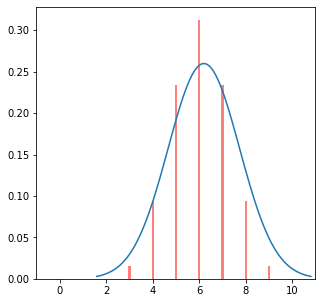

In [68]:
m = 4
p = .8 # the true margin
audited_margins = np.zeros(2**(n - m))
ax.cla()

for i in range(2**(n - m)):    
    audited_margins[i] = m*p + (np.sum([int(j) for j in list('{0:0b}'.format(i))])) # Add four votes for the "winner"

ax.hist(audited_margins, bins=np.arange(0, 11), rwidth=0.1, align='left', color='red', alpha=0.5,  density=True)


mu = np.mean(audited_margins)
variance = n*(mu/n)*(1 - mu/n)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
ax.set_xlim(-1, 11)
counts, _ = np.histogram(audited_margins, range=(0, 11))
greater_than_5 = sum(counts[5:])
print('confidence: {:2.2f}%'.format(100*greater_than_5/2**(n- m)))
fig

Hmm, that doesn't quite look right. Why is that? It could be because our n is very small here, certainly compared to infinity! It could also be that because the normal distrubtion is continuous, it has a lot more places to "pack" probabilities, meaning it doesn't need to grow as high to add up to 1. 

To examine this, let's imagine that we take many more trials in a much larger election. We'll normalize our margins just so we can compare back to our original PMF.

0.553524199845511 0.646475800154489


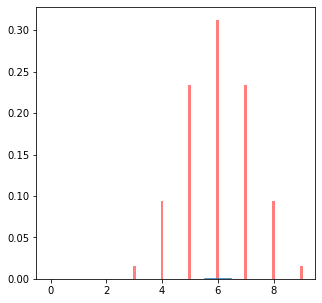

In [87]:
ax.cla()
p = .6
n = 1000
mu = p*n
variance = p*n*(1 - p)
sigma = math.sqrt(variance)
print((mu - 3*sigma)/n, (mu+3*sigma)/n)
x = np.linspace((10/n)*(mu - 3*sigma), (10/n)*(mu + 3*sigma), 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))

ax.hist(audited_margins, bins=np.arange(0, 11), rwidth=0.1, align='left', color='red', alpha=0.5,  density=True)
# ax.set_xlim(-1, 11)

fig